In [1]:
# 이 셀은 VSCode 환경 사용시에만 실행할 것!
%cd ..

c:\Users\jeong\Desktop\space-decomposition


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import time
import os
import copy
import csv

from PIL import Image

from src.models.population_estimators import PopulationEstimator

# 대화 모드
plt.ion()
plt.rcParams["figure.figsize"] = (6, 6)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
transform = transforms.Compose([
    # transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5, .5, .5], std=[.5, .5, .5]),
])


target_dir = "data/rough_population"
dataset = torchvision.datasets.ImageFolder(root=target_dir, transform=transform)
class_names = dataset.classes
num_classes = len(class_names)


dataset_sizes = {}
dataset_sizes["train"] = int(0.95 * len(dataset))
dataset_sizes["val"] = len(dataset) - dataset_sizes["train"]


datasets = {}
datasets["train"], datasets["val"] = torch.utils.data.random_split(
    dataset, [dataset_sizes["train"], dataset_sizes["val"]])


dataloaders = {}
dataloaders["train"] = torch.utils.data.DataLoader(datasets["train"],
                                                   batch_size=16,
                                                   shuffle=True,
                                                   num_workers=8)
dataloaders["val"] = torch.utils.data.DataLoader(datasets["val"],
                                                   batch_size=8,
                                                   shuffle=True,
                                                   num_workers=4)

for x in ["train", "val"]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: {}({})".format(class_names, num_classes))

Loaded 4469 images under train
Loaded 236 images under val
Classes: ['0', '1', '2', '3'](4)


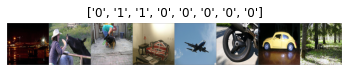

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([.5, .5, .5])
    std = np.array([.5, .5, .5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

def visualize_dataset():
    inputs, labels = next(iter(dataloaders['val']))
    out = torchvision.utils.make_grid(inputs)

    imshow(out, title=[class_names[x] for x in labels])

visualize_dataset()

In [5]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval() # 평가 모드; batch norm, dropout, ... X
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets = (targets != 0).float().unsqueeze(1)

            outputs, outputs2 = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'ground truth:{class_names[targets[j]]}, predicted: {class_names[preds[j]]}, existence: {outputs2[j]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [6]:
def eval_model(model, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    for i, data in enumerate(dataloaders["val"]):
        model.eval()
        inputs, targets = data[0].to(device), data[1].to(device)
        targets2 = (targets != 0).float().unsqueeze(1)

        outputs, outputs2 = model(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, targets) + (criterion2(outputs2, targets2) * 2)

        loss_test += loss.item()
        acc_test += torch.sum(preds == targets.data)
        
    avg_loss = loss_test / dataset_sizes["val"]
    avg_acc = acc_test.double() / dataset_sizes["val"]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))

## 모델 생성

In [7]:
backbone = torch.hub.load('pytorch/vision:v0.6.0', 'mobilenet_v2', pretrained=True)

# 이전 레이어 학습 정지
for param in backbone.features.parameters():
    param.require_grad = False

# 새로운 레이어 추가
input_channel = 2048
backbone.classifier = nn.Sequential(
            nn.Linear(backbone.last_channel, 2048),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(2048, 2048),
            nn.ReLU(True),
            nn.Dropout(),
        )

model = PopulationEstimator(backbone, input_channel, 4)
model.to(device)

Using cache found in C:\Users\jeong/.cache\torch\hub\pytorch_vision_v0.6.0


PopulationEstimator(
  (backbone): MobileNetV2(
    (features): Sequential(
      (0): ConvBNReLU(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNReLU(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), 

In [8]:
criterion = nn.CrossEntropyLoss()
criterion2 = nn.BCEWithLogitsLoss()

optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## 훈련전

Test before training

Evaluation completed in 0m 6s
Avg loss (test): 0.3520
Avg acc (test): 0.2712


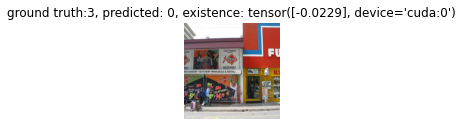

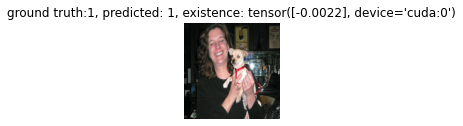

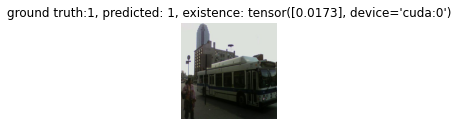

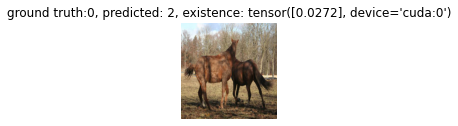

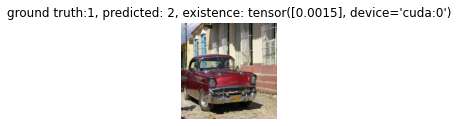

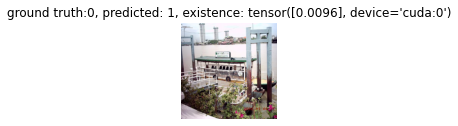

In [9]:
print("Test before training")
eval_model(model, criterion)
visualize_model(model)

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        # training
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        model.train(True)
        
        # 데이터 반복
        for i, data in enumerate(dataloaders["train"]):
            inputs, targets = data[0].to(device), data[1].to(device)
            targets2 = (targets != 0).float().unsqueeze(1)
            
            # 파라미터 경사도 초기화
            optimizer.zero_grad()
            
            outputs, outputs2 = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, targets) + (criterion2(outputs2, targets2) * 2)
            
            # 역전파
            loss.backward()
            # 최적화
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == targets.data)
        
        avg_loss = loss_train / dataset_sizes["train"]
        avg_acc = acc_train.double() / dataset_sizes["train"]
        
        # validation
        model.train(False)
        model.eval()
            
        for i, data in enumerate(dataloaders["val"]):
            inputs, targets = data[0].to(device), data[1].to(device)
            targets2 = (targets != 0).float().unsqueeze(1)

            outputs, outputs2 = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, targets) + (criterion2(outputs2, targets2) * 2)
            
            loss_val += loss.item()
            acc_val += torch.sum(preds == targets.data)
        
        avg_loss_val = loss_val / dataset_sizes["val"]
        avg_acc_val = acc_val.double() / dataset_sizes["val"]
        
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [11]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/30
----------
Epoch 0 result: 
Avg loss (train): 0.1188
Avg acc (train): 0.6024
Avg loss (val): 0.1623
Avg acc (val): 0.7161
----------

Epoch 1/30
----------
Epoch 1 result: 
Avg loss (train): 0.0854
Avg acc (train): 0.7138
Avg loss (val): 0.1919
Avg acc (val): 0.7331
----------

Epoch 2/30
----------
Epoch 2 result: 
Avg loss (train): 0.0721
Avg acc (train): 0.7523
Avg loss (val): 0.1665
Avg acc (val): 0.7288
----------

Epoch 3/30
----------
Epoch 3 result: 
Avg loss (train): 0.0591
Avg acc (train): 0.7753
Avg loss (val): 0.1578
Avg acc (val): 0.7415
----------

Epoch 4/30
----------
Epoch 4 result: 
Avg loss (train): 0.0556
Avg acc (train): 0.7814
Avg loss (val): 0.2079
Avg acc (val): 0.7669
----------

Epoch 5/30
----------
Epoch 5 result: 
Avg loss (train): 0.0491
Avg acc (train): 0.7991
Avg loss (val): 0.2026
Avg acc (val): 0.7034
----------

Epoch 6/30
----------
Epoch 6 result: 
Avg loss (train): 0.0461
Avg acc (train): 0.8078
Avg loss (val): 0.1778
Avg acc (val): 0.78

In [12]:
torch.save(model.state_dict(), 'outputs/models/model512_1.pt')

## 모델 평가

In [13]:
eval_model(model, criterion)


Evaluation completed in 0m 6s
Avg loss (test): 0.1778
Avg acc (test): 0.7881


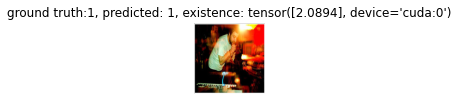

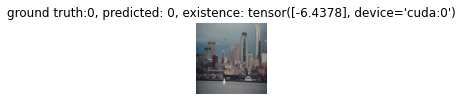

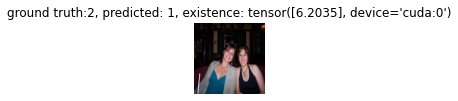

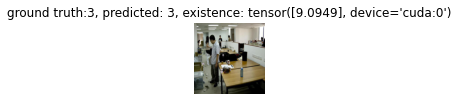

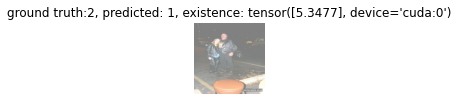

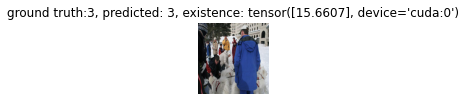

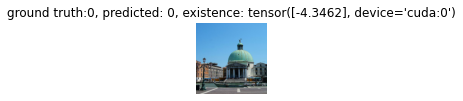

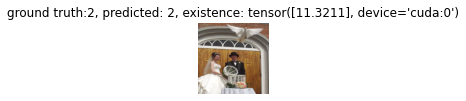

In [14]:
visualize_model(model, num_images=8)